# Machine learning to predict new crescent moon visibility

## Imports

In [118]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Issue with xgboost & new pandas version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# MACHINE LEARNING IMPORTS
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
import shap

## Options and setup

In [119]:
MULTI_OUTPUT_METHOD = False #Replace naked eye seen column with array of methods
MULTI_LABEL_METHOD = False #Replace naked eye seen column with either seen, visual aid or not seen
XGBOOST = True #Use xgboost forest or random forest
RANDOM = False # replace data with random arrays
CLOUDCUT = False # cut all complete cloud cover data points
GRID_SEARCH = False # gridsearch for best hyperparameters
REPEAT_ACCURACY = False #Run 20 times and calculate average accuracy
LINUX = True #Use linux file paths
USE_GPU = True #Use a GPU

TITLE = f"{'XGBoost' if XGBOOST else 'Random Forest'} {'Eye' if not MULTI_LABEL_METHOD and not MULTI_OUTPUT_METHOD else ''}{'Multi-label' if MULTI_LABEL_METHOD else ''}{'Multi-output' if MULTI_OUTPUT_METHOD else ''} visibility"

## Hyperparameters

In [120]:
if XGBOOST:
    if MULTI_OUTPUT_METHOD:
        PARAMS = {'learning_rate': 0.1733, 'max_depth': 6, 'n_estimators': 50}
    elif MULTI_LABEL_METHOD:
        PARAMS = {'learning_rate': 0.4183, 'max_depth': 2, 'n_estimators': 100}
    else:
         PARAMS = {'learning_rate': 0.55, 'max_depth': 3, 'n_estimators': 110}
         
else: #Random forest
    if MULTI_OUTPUT_METHOD:
        PARAMS = {}
    elif MULTI_LABEL_METHOD:
        PARAMS = {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
    else:
         PARAMS = {'max_depth': 12, 'n_estimators': 150}

## Reading in data

In [121]:
data_file = '..\\Data\\moon_sighting_data.csv'
if LINUX:
    data_file = '../Data/moon_sighting_data.csv'

data = pd.read_csv(data_file)

print(f"Loaded {data.shape[0]} rows")

#Drop index, dependent parameters (q value etc) and visibility scale
#data = data.drop(["Index","q","W","q'","Visibility","Source"], axis = 1)
#data = data.drop(["Index","q","W","q'","Visibility","Source","Date", "Longitude","Latitude"], axis = 1)
#data = data.drop(["Index","q","W","q'","Visibility","Source","Date", "Longitude","Latitude","Sunset","Moonset"], axis = 1)
#data = data.drop(["Index","q","W","q'","Visibility","Source","Date", "Longitude","Latitude","Sunset","Moonset","Sun Alt", "Sun Az", "Moon Alt", "Moon Az"], axis = 1)
data = data.drop(["Index","q","W","q'","Visibility","Source","Date", "Longitude","Latitude","Sunset","Moonset","ARCV", "DAZ"], axis = 1)
if MULTI_OUTPUT_METHOD:
    data = data.drop(["Seen", "Method"], axis = 1) # replaced by methods column

    ptype = ["Seen_eye", "Seen_binoculars", "Seen_telescope", "Seen_ccd","Not_seen"]

elif MULTI_LABEL_METHOD:
    data = data.drop(["Seen", "Methods"], axis = 1) # replaced by method column
    data["Method"] = data["Method"].replace("Seen_binoculars", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_telescope", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_ccd", "Seen_with_aid")

    ptype = ["Seen_eye", "Seen_with_aid", "Not_seen"]

else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1) #Only use seen

    ptype = ["Seen", "Not_seen"]

if CLOUDCUT:
    data = data[data["Cloud Level"] <= 0.5]
    #data = data[data["Cloud Level"] == 0]

print(f"Using {data.shape[0]} rows")

Loaded 5302 rows
Using 4518 rows


## ML Training

In [122]:
# List of features without label feature
variable_list =  data.columns.tolist()
features = variable_list
print(variable_list)

if MULTI_OUTPUT_METHOD:
    orig_y = np.array(data['Methods'].str.split(";"))
    mlb = MultiLabelBinarizer(classes=ptype)
    y = mlb.fit_transform(orig_y)
    features.remove('Methods')
    # test = pd.DataFrame(y, columns=mlb.classes_)
    # print(test.head(10))

elif MULTI_LABEL_METHOD:
    data["Method"] = data["Method"].replace("Seen_eye",2) #XGboost needs 1 and 0
    data["Method"] = data["Method"].replace("Seen_with_aid",1)
    data["Method"] = data["Method"].replace("Not_seen",0)
    y = np.array(data['Method'])
    features.remove('Method')
    
else:
    if XGBOOST:
        data["Seen"] = data["Seen"].replace("Seen",1) #XGboost needs 1 and 0
        data["Seen"] = data["Seen"].replace("Not_seen", 0)
    y = np.array(data['Seen'])
    features.remove('Seen')
    pos = 'Seen' # for ROC curve +ve result

X = data[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split

['Moon Age', 'Lag', 'Moon Alt', 'Moon Az', 'Sun Alt', 'Sun Az', 'Moon-Earth Dist', 'Sun-Moon Dist', 'ARCL', 'Illumination', 'Parallax', "W'", 'Cloud Level', 'Seen']


In [123]:
# Produce randomforest classifier model and fit to training data
def select_model():
    if XGBOOST:
        if MULTI_OUTPUT_METHOD:
            if USE_GPU:
                method = "gpu_hist"
            else:
                method = "hist"
            model = XGBClassifier(tree_method=method, n_jobs=-1)
        else:
            model = XGBClassifier(n_jobs=-1)
    else:
        if MULTI_OUTPUT_METHOD:
            model = MultiOutputClassifier(RandomForestClassifier(n_jobs=-1))
        else:
            model = RandomForestClassifier(n_jobs=-1)

    model = model.set_params(**PARAMS)
    return model
model = select_model()
# Fitting takes the input and "truth" data for classification purposes
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.55, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=110, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [124]:
def get_easiest_method_array(methods):
    easiest_methods = np.zeros(methods.shape)
    easiest_methods[np.arange(0,methods.shape[0],1),np.argmax(methods,axis=1)] = 1
    return easiest_methods

def get_easiest_method_names(methods):
    easiest_methods = get_easiest_method_array(methods)
    return mlb.inverse_transform(easiest_methods.astype(int))

# Produce predictions for the classification of your training dataset using your model:
y_pred = model.predict(x_train)

# plot the accuracies of said predictions
print("Accuracy on training dataset:",accuracy_score(y_train, y_pred))
rf_acc_train = accuracy_score(y_train, y_pred)
y_pred = model.predict(x_test)

print("Accuracy on testing dataset:", accuracy_score(y_test, y_pred))
rf_acc_test = accuracy_score(y_test, y_pred)

if MULTI_OUTPUT_METHOD:
    print("Accuracy on testing dataset (easiest method only):", accuracy_score(get_easiest_method_names(y_test), get_easiest_method_names(y_pred)))

Accuracy on training dataset: 0.9811842833425567
Accuracy on testing dataset: 0.9103982300884956


## ROC curve

In [125]:
# Get predicted class probabilities for the test set 
if MULTI_OUTPUT_METHOD:
    #y_pred_prob = rf.predict_proba(x_test)
    #roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("Not currently working")
elif MULTI_LABEL_METHOD:
    y_pred_prob = model.predict_proba(x_test)
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
    print(f"ROC curve {roc_auc}")
else:
    y_pred_prob = model.predict_proba(x_test)[:, 1] 
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC curve {roc_auc}")
print('Oob Score: ', model.score(x_test, y_test))

ROC curve 0.9593687223784653
Oob Score:  0.9103982300884956


In [126]:
# # plot your confusion matrix
# if MULTI_OUTPUT_METHOD:
#     cm = confusion_matrix(get_easiest_method_names(y_test), get_easiest_method_names(y_pred),normalize = 'true')
# else:
#     cm = confusion_matrix(y_test, y_pred,normalize = 'true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)
# disp.plot()
# plt.title(f"Confusion matrix ({TITLE})")
# plt.show()

In [127]:
# # Plot importance
# if not XGBOOST and MULTI_OUTPUT_METHOD:
#     feat_impts = [] 
#     for clf in model.estimators_:
#         feat_impts.append(clf.feature_importances_) 

#     importance = np.mean(feat_impts, axis=0)

# else:
#     importance = model.feature_importances_

# ytix = features
# plt.barh(range(len(features)), importance)
# plt.yticks(range(len(features)), features)
# plt.xlabel("Importance")
# plt.ylabel("Features")
# plt.title(f"Importance Graph ({TITLE})")
# plt.show()

In [128]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [129]:
# shap.initjs()
# force_plot = shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

# HTML(f"<div style='background-color:White;'>{shap.getjs() + force_plot.html()}</div>")

In [130]:
# shap.initjs()
# force_plot = shap.force_plot(
#     explainer.expected_value, shap_values[:1000, :], X.iloc[:1000, :]
# )
# HTML(f"<div style='background-color:White;'>{shap.getjs() + force_plot.html()}</div>")

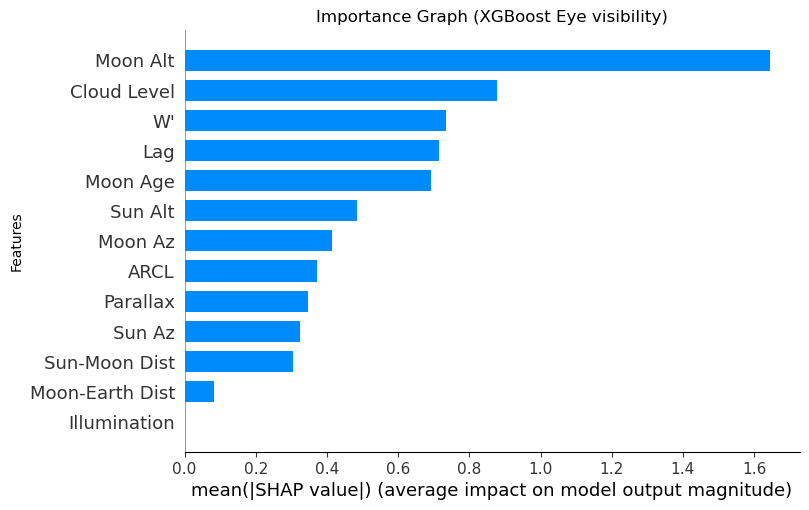

In [131]:
plt.figure(figsize=(6,10))
shap.summary_plot(shap_values, X, plot_type="bar",plot_size=[8,5],show=False)
plt.ylabel("Features")
plt.title(f"Importance Graph ({TITLE})")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


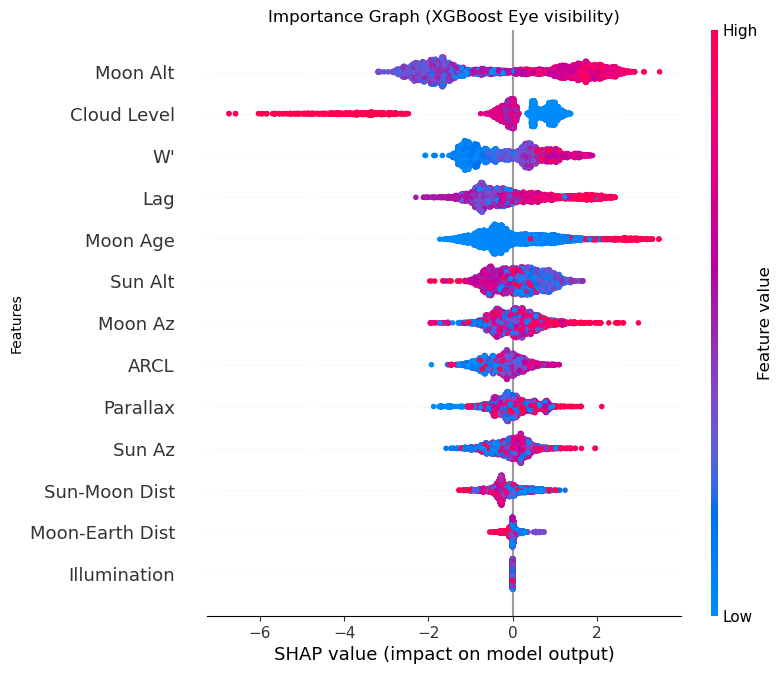

In [132]:
shap.summary_plot(shap_values, X,show=False)
plt.ylabel("Features")
plt.title(f"Importance Graph ({TITLE})")
plt.show()

In [133]:
test = np.array([0,1,3,5.9,-56,3,-2])
print(test.astype(np.uint8))

[  0   1   3   5 200   3 254]
